In [12]:
import json
import os.path
import shutil
import cv2
import numpy as np


def get_direction_label(degree):
    # Normalize the degree to be between 0 and 360
    degree = degree % 360
    if 0 <= degree < 45 or 315 <= degree <= 360:
        return 'N'
    elif 45 <= degree < 135:
        return 'E'
    elif 135 <= degree < 225:
        return 'S'
    elif 225 <= degree < 315:
        return 'W'


def create_color_map():
    # Assign a unique color to each class
    color_map = {
        'void': (1, 1, 1),  # Background (including "trees")
        'flat': (255, 255, 255),
        'N': (255, 0, 0),
        'S': (0, 255, 0),
        'E': (0, 0, 255),
        'W': (255, 255, 0),
    }
    return color_map


def create_mask(image_shape, polygons, color_map):
    mask = np.ones(image_shape + (3,), dtype=np.uint8)
    for region_id, region_data in polygons.items():
        shape_attributes = region_data['shape_attributes']
        points_x = shape_attributes['all_points_x']
        points_y = shape_attributes['all_points_y']
        class_label = region_data['region_attributes']['building']
        if class_label not in ["tree", "flat"]:
            class_label = get_direction_label(int(class_label))
        color = color_map.get(class_label, color_map['void'])

        pts = np.array(list(zip(points_x, points_y)), dtype=np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.fillPoly(mask, [pts], color)

    return mask


# Load VIA annotations from JSON file
folders = ['train', 'test', 'val']
for folder in folders:

    with open(f'deeproof-release/data/deeproof/{folder}/via_region_data.json') as json_file:
        data = json.load(json_file)

    # Create a color map
    color_map = create_color_map()

    with open('segmentation_dataset/colormap.txt', 'w') as file:
        for class_id, (class_name, rgb_values) in enumerate(color_map.items()):
            # Convert RGB values to a string
            rgb_string = '\t'.join(str(value) for value in rgb_values[:])  # Exclude alpha for this format
            # Write the class name, RGB values, and class ID to the file
            file.write(f"{class_name}\t{rgb_string}\t{class_id+1}\n")

    # Iterate through each image in the dataset
    for index , (image_filename, image_data) in enumerate(data.items()):
        image_shape = (512, 512)
        polygons = image_data['regions']

        # Create mask for the current image
        mask = create_mask(image_shape, polygons, color_map)
        if len(np.unique(mask)) > 1:
            # Save the mask as an image
            image_filename = image_filename.split('.jpg')[0] + '.jpg'
            shutil.copy(f'deeproof-release/data/deeproof/{folder}/{image_filename}' , f'{os.path.curdir}/segmentation_dataset/rgb/{index}.jpg')
            cv2.imwrite(f'segmentation_dataset/GT_color/{index}.png', mask)


# Explanation for preprocess : The dataset format was VIA (VGG Image Annotator), so we changed the format for segmentation maps, In the dataset there are 20 images with not annotated , so we removed these.


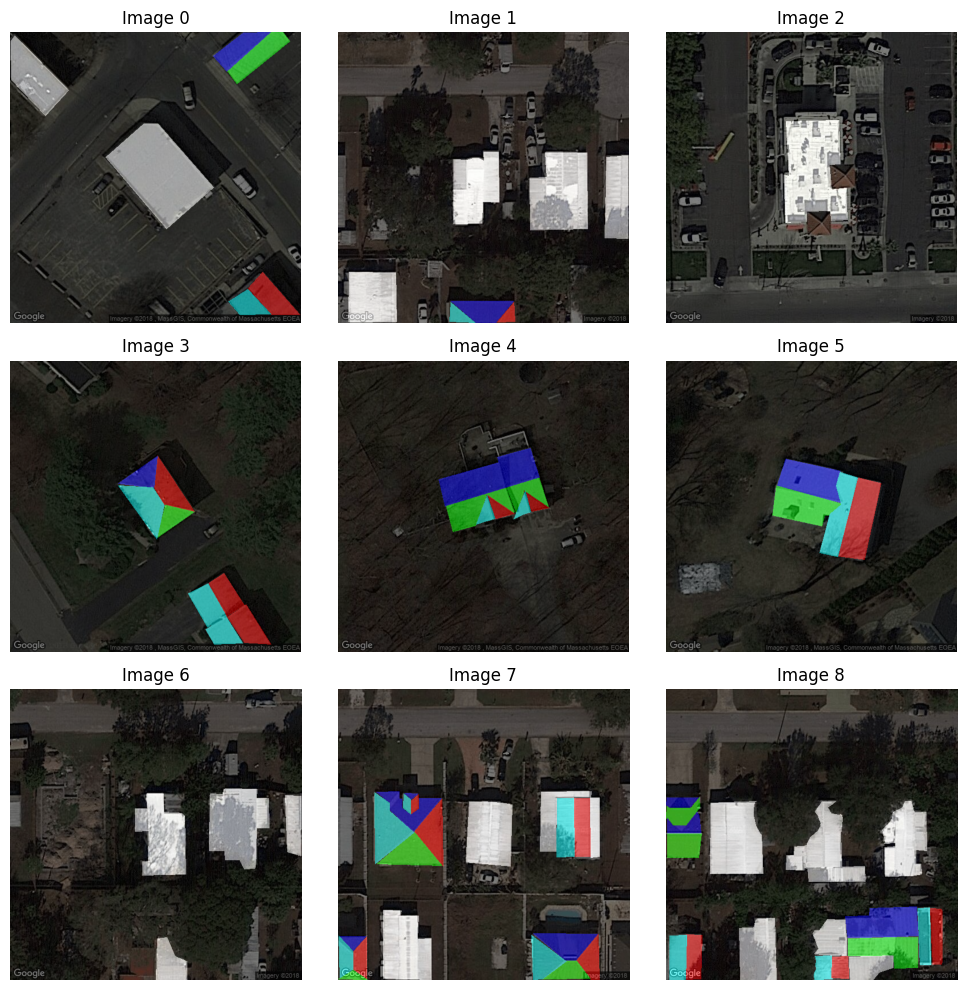

In [13]:
# Examples for masks
import matplotlib.pyplot as plt
import cv2
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop through the images
for i in range(9):
    # Load the mask and image
    mask = cv2.imread(f'segmentation_dataset/GT_color/{i}.png')
    img = cv2.imread(f'segmentation_dataset/rgb/{i}.jpg')
    
    # Blend the images
    image = np.array(img) * 0.5 + mask * 0.5
    image = image.astype(np.uint8)

    # Display the blended image in the subplot
    row = i // 3  # Calculate the row index
    col = i % 3   # Calculate the column index
    axes[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(f'Image {i}')
    axes[row, col].axis('off')  # Turn off axis labels

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()